Indeed, in many situations you don't really need to know the implementation details. However, having a good understanding of how thins work can help you quickly home in on the appropriate model, the right training alogrithm to use, and a good set of hyperparameters for your task.

In this chapter, we will start by looking at the Linear Regression model, one of the simplest models there is. We will discuss 2 different ways to train it:
- Using a direct "closed-form" equation that directly computes the model parameters that best fit the model to the training set(i.e., the model parameters that minimize the cost function over the training set).
- Using an iterative optimization approach, called Gradient Descent(GD), that gradually tweaks the model parameters to minimize the cost function over the training set, eventually converging to the same set of parameters as the first method.

Next will look at the Polynomial Regression, a more complex model that can fit nonliear datasets. It has more parameters than Linear Regression and is more prone to overfitting the training data. Then we will look at several regularization techniques that can reduce the risk of overfitting the training set.

Finally, we will look at 2 more models that are commonly used for classification tasks:Logistic Regression and Softmax Regression.

# Linear Regression
Generally, a linear model makes a prediciton by simply computing a weighted sum of the input features, plus a constant called the *bias term or intercept term*.
$$\hat{y} = \theta_0+\theta_1x_1+\theta_2x_2+\dots++\theta_nx_n$$
- $\hat{y}$ is the predicted value.
- $n$ is the number of features.
- $x_i$ is the i^th feature value.
- $\theta_j$ is the j^th model parameter(including the bias term \theta_0 and the feature weights $\theta_0,\theta_1,\theta_2,\dots,\theta_n$

This can also be written much more concisely using a vectorized form.
$$\hat{y}=h_\theta(X)=\theta^T\cdot X$$
- $\theta$ is the model's *parameter vector*, containing the bias term $\theta_0$ and the feature weights $\theta_0$ to $\theta_n$
- $\theta^T$ is the transpose of $\theta$( a row vector instead of a column vector.
- $X$ is the instance's *feature vector*, containing $x_0$ to $x_n$, with $x_0$ is always to 1.
- $\theta^T\cdot$ $X$ is the dot product of $\theta^T$ and $X$
- $h_\theta$ is the hypothesis function, using the model parameters $\theta$.

So this is the LR model, now how do we train it? For this purpose, we first need a measure of how well(or poorly) the model fits the training data. A common performance measure of a regression model is the Root Mean Square Error(RMSE). Therefore, to train a LR model, you need to find the value of $\theta$ that minimizes the RMSE. In practice, it is simpler to minimize the MSE than the RMSE, and it leads to the same results(because the value that minimizes a function also minimizes its square root).

The MSE of a LR hypothesis $h_\theta$ on a training set $X$ is calculated using this equation.$$MSE(X,h_\theta)=\frac{1}{m}\sum_{i=1}^m(\theta^T\cdot X^{(i)} - y^{(i)})^2$$

NOTE: We write $h_\theta$ instead of $h$ in order to make it clear that the model is parametrized by the vector $\theta$. To simplify the notations, we will just write MSE($\theta$) instead of $MSE(X,h_\theta)$.

## The Normal Equation
To find the value of $\theta$ that minimizes the cost function, there is a *closed-form solution*. In other words, a mathematical equation that gives the result directly. This is called the **Normal Equation**.$$\hat{\theta}=(X^T\cdot X)^{-1}\cdot X^T\cdot y$$
- $\hat{\theta}$ is the value of $\theta$ that minimizes the cost function.
- $y$ is the vector of target values containing $y^{(1)}$ to $y^{(m)}$.

Let's generate some linear-looking data to test this equation:

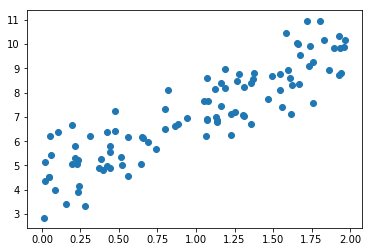

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

X = 2*np.random.rand(100,1)
y = 4+3*X + np.random.randn(100, 1)
plt.scatter(X,y)

Now compute $\hat{\theta}$ using the Normal Equation.

In [2]:
X_b = np.c_[np.ones((100,1)), X] # add x0=1 to each instance
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
theta_best

array([[4.36836325],
       [2.76201429]])

We would have hoped for $\theta_0=4$ and $\theta_1=3$ instead of $\theta_0=3.762$ and $\theta_1=3.129$. Closed enough, but the noise made it impossible to recover the exact parameters of the original function.

Now we could use $\hat{\theta}$ to make predicitons.

In [3]:
X_new = np.array([[0],[2]])
X_new_b = np.c_[np.ones((2,1)), X_new] # add x0=1 to each instance
y_predict = X_new_b.dot(theta_best)
y_predict

array([[4.36836325],
       [9.89239184]])

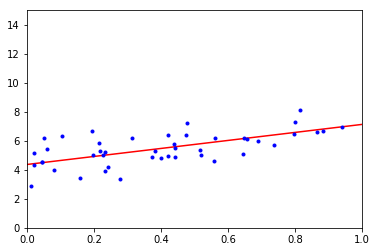

In [4]:
plt.plot(X_new, y_predict, 'r-')
plt.plot(X,y,'b.')
plt.axis([0,1,0,15])
plt.show()

The equivalent code using Scikit-Learn looks like this:

In [5]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X,y)
# 以下两个参数：截距，系数(1,2...n)
lin_reg.intercept_, lin_reg.coef_

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


(array([4.36836325]), array([[2.76201429]]))

In [6]:
lin_reg.predict(X_new)

array([[4.36836325],
       [9.89239184]])

## Computational Complexity
The Normal Equation gets very slow when the number of features grows large(e.g.,1000,000).

So we will look at very different ways to train a Linear Model, **better suited for cases where there are a large number of features, or too many training instances to fit in memory.**

## Gradient Descent
**Gradient Descent** is a very genetic optimization algorithm capable of finding optimal solutions to a wide range of problems. **The general idea of Gradient Descent is to tweak parameters iteratively in order to minimize a cost funciton.**

This is what GD exactly does: It measures the local gradient of the error function with regards to the parameter vector $\theta$, and it goes in the direction of descending gradient. Once the gradient is zero, you have reached a minimum!

Concretely, you start by filling $\theta$ with random values(called **random initialization**), and then you improve it gradually, taking one baby step at a time, each step attempting to decrease the cost function(e.g., the MSE), until the algorithm **converges** to a minimum.

An important parameter in Gradient Desent is the size of the steps, determined by the **learning rate** hyperparameter. If the learning rate is too small, then the algorithm wil have to go through many iterations to converge, which will take a long time. On the other hand, if the learning rate it too high, you might jump across the valley and endup on the other side, possibly enen higher up than you were before. This migh make the algorithm diverge(发散),  failing to find a good solution.

### Two main challenges with Gradient Descent
1. if the random initialization starts the algorithm on the left, then it will converge to a **local minimum**, which is not as good as the **global minimum**. 
2. If it starts on the right, then it will take a very long time to cross the plateau, and if you stop too early you will never reach the global minimum.

**Fortunately, the MSE cost function for a Linear Regression model happens to be a *convex function*, which means that there is no local minimum, just one global minimum. It is also a continuous fuction with a slope that never changes abruptly.** These two facts have a great consequence: Gradient Descent is guaranteed to approach arbitrarily close the gloabal minimum(if wait long enough and the learning rate is not too high).

**TIPS: When using Gradient Descent algorithm, ensure that all features have a similar scale**.

Training a model means searching for a combination of model parameters that minimizes a cost function(over the training set). The more parameters a model has, the more dimensions the model's **parameter space** is, and the harder the search is.

### Batch Gradient Descent
To implement Gradient Descent, you need to calculate how much the cost function will change if you change $\theta_j$ a little bit. This is called **partial derivative**.

*Equation4-5:partial derivatives of the cost functions:*
$$\frac{\partial}{\partial\theta_j}MSE(\theta)=\frac{2}{m}\sum_{i=1}^m(\theta^T\cdot x^{(i)}-y^{(i)})x_j^{(i)}$$

Compute these gradients all in one go. THe gradient vector, noted $\nabla_\theta MSE(\theta)$, contains all the partial derivatives of teh cost fuction(one for each model parameter).

*Equation4-6:partial derivatives of the cost functions:*
$$\nabla_\theta MSE(\theta)=\left(
    \begin{matrix}
        \frac{\partial}{\partial\theta_0}MSE(\theta)\\
        \frac{\partial}{\partial\theta_1}MSE(\theta)\\
        \vdots\\
        \frac{\partial}{\partial\theta_n}MSE(\theta)\\
    \end{matrix}
\right)
= \frac{2}{m}X^T\cdot (X\cdot \theta - y)
$$

Notice that this formula involves calculations over the full training set **X**, at each Gradient Descent step! This is why the algorithm is called *Batch Gradient Descent*: It uses the hole batch of training data at every step. As a result it is terribly slow on every large training sets. However, training a Linear Regression model when there are hundreds of thousands of features is much faster using Gradient Descent than using the Normal Equation.

Once you have the gradient vector, which points uphill, just go in the opposite direction to go downhill. This means subtracting $\nabla_\theta MSE(\theta)$ from $\theta$. This is where the learning rate $\eta$ comes to play: Multiply the gradient vector by $\eta$ to determine the size of the downhill step.

*Equation4-7: Gradient Descent step*
$$\theta^{next step}=\theta-\eta\nabla_\theta MSE(\theta)$$
Here is a quick implementation of this algorithm:

In [7]:
eta = 0.1 #learning rate
n_iterations = 1000
m = 100

theta = np.random.randn(2,1) # random initialization

for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta*gradients

theta

array([[4.36836325],
       [2.76201429]])

In [8]:
eta = 0.5 #learning rate
n_iterations = 1000
m = 100

theta = np.random.randn(2,1) # random initialization

for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta*gradients

theta

array([[-8.91794902e+73],
       [-1.06454579e+74]])

In [9]:
eta = 0.01 #learning rate
n_iterations = 1000
m = 100

theta = np.random.randn(2,1) # random initialization

for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta*gradients

theta

array([[4.31334337],
       [2.80810573]])

When $\eta = 0.1$, we get $\theta$ exactly equal to what Normal Equation found. Gradient Descent worked perfectly. But when $\eta =$ 0.5 or 0.01, the results changed. 

**How to find a good learning rate and iterations**:
- To find a good learning rate, we can use grid search.
- To  find a good iteration, a simple solution is to set a very large number of iterations but to interrupt the algorithm when the gradient vector becomes tiny -- that is, when its norm becomes smaller than a tiny number $\epsilon$(called the **tolerance**) -- because this happens when Gradient Descent has (almost) reached the minimum.

#### Convergence Rate
When the cost function is convex and its slope does not change abruptly(e.g., MSE cost function), it can be shown that Batch Gradient Descent with a fixed learning rate has a **convergence rate** of $O(\frac{1}{iterations})$. In other works, if you divide the tolerance $\eta$ by 10, then the algorithm will have to run about 10 times more iterations.

### Stochastic Gradient Descent(随机梯度下降)

**The main problem with Batch Gradient Descent is the fact that it uses the whole training set to compute the gradients at every step, which makes it very slow when the training set is large.**

**Stochastic Gradient Descent just picks A random instance in the training set at every step and computes the gradients based only on that single instance.** Obviously, this makes the algorithm much faster. SGD can be implemented as an out-of-core algorithm. 

On the other hand, due to its stochastic nature, this algorithm is much less regular than BGD: 
- instead of gently decreasing until it reaches the minimum, the cost function will bounce up and down, decreasing only on average. **Over time it will end up very close to the minimum, but not optimal.**
- But this acutally help the algorithm jump out of local minima,**so SGD has a better chance of inding the global minimum than BGD does.**

**One solution to this dilemma(进退两难) is to gradually reduce the learning rate.** The steps start out large, then get smaller and smaller, allowing the algorithm to settle at the global minimum. This process is called **simulated annealing(模拟退火)**. The function that determines the learning rate at each iteration is called the **learning schedule**.If the learning rate is reduced too quickly, you may get stuck in a local minimum, or even end up frozen halfway to the minimum. If the learning rate is reduced too slowly, you may jump around the minimum for a long tme and end up with a suboptimal solution if you halt training too early.

A simple example of SGD using a simple leanring schedule:

In [10]:
n_epochs = 50
t0, t1 =5, 50 # learning schedule hyperparameters

def learning_schedule(t):
    return t0/(t+t1)

theta = np.random.randn(2,1) #random initializaiton
for epoch in range(n_epochs):
    for i in range(m):
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2*xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta*gradients

In [11]:
theta

array([[4.37140899],
       [2.72631413]])

By convention we iterate by  rounds of m iterations; each round is called an **epoch**. While BGD code iterated 1000 times through the whole training set, this code goes through the training set only 50 times and reaches a fairly good solution.

Note that sinece instances are picked randomly, some instances may be picked several times per epoch while others may not be picked at all. If you want to be sure that the algorithm goes through every instance at each epoch, another approach is to shuffle the training set, then go through it intance by instance, the shuffle it again, and so on. However, htis generally converges more slowly. 

An example of Linear Regression using SGD with Scikit-Learn is below. You can use `SGDRegressor` class, which defaults to optimizing the squared error cost function. The following code runs 50 epochs, starting with a learning rate of 0.1(`eta0=0.1`), using the default learning schedule(different from the preceding one), and it does not use any regulariztion(`penalty=None`)

In [12]:
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(n_iter=50, penalty=None, eta0=0.1)
sgd_reg.fit(X,y.ravel())

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.1,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', max_iter=None, n_iter=50, penalty=None,
       power_t=0.25, random_state=None, shuffle=True, tol=None, verbose=0,
       warm_start=False)

In [13]:
sgd_reg.intercept_, sgd_reg.coef_

(array([4.4046334]), array([2.79291442]))

### Mini-batch Gradient Descent
**What is different in Mini-batch Gradient Descent:At each step, instead of computing the gradients based on the full training set(as in the Batch GD) or based on just on instance(as in Stochastic GD), Mini-batch GD computes the gradients on small random sets of instances called Mini-batches.** 

The main advantage of Mini-batch GD over Stochastic GD is that you can get a performance boost from hardwar optimization of matrix operation, especially when using GPUs. The algorithm's progress in parameter space is less erratic(飘忽不定的,因为SGD 是随机选取一个样本进行梯度计算） than with SGD, especially with fairly large mini-batches. As a result, Mini-batch GD will end up walking around a bit closer to the minimum than SGD. But, on the other hand, it may be harder for it to escape from local minima.

**BGD actually stops at the minimum, while both SGD and Mini-batch GD continue to walk round. However, Batch GD takes a lot of time to take each step, and SGD and Mini-batch GD would also reach the minimum with a good learning schedule.**

# Polynomial Regression
If data is more complex than a simple straight line, we can use a linear model to fit nonlinear data. A simple way to do this is to add powers of each feature as new features, then train a linear model on this extended set of features. This technique is called **Polynomial Regression**.

Here is an example:

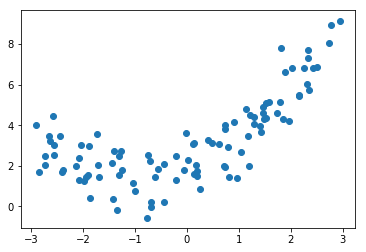

In [14]:
m = 100
X = 6*np.random.rand(m,1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m,1)

plt.scatter(X,y)

In [15]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
X[0], X_poly[0]

(array([2.50631636]), array([2.50631636, 6.28162168]))

`X_poly` now contains the original feature of `X` plus the square of this feature. Now we can fit a `LinearRegression` model to this extended training data.

In [16]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.90090587]), array([[0.94674757, 0.49144064]]))

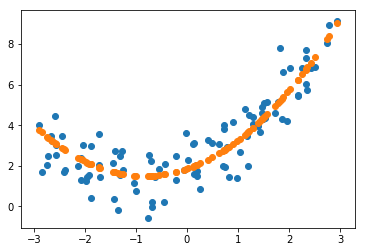

In [17]:
plt.scatter(X,y)
plt.scatter(X, 0.52637411*X**2 + 0.87633483*X + 1.86409705)

Note that when there are multiple features, Polynomial Regression is capable of finding relationships between features. This is made possible by the fact that `PolynominalFeature` also adds all combinations of features up to the given degree. For example, if there are two features a and b, `PolynomialFeatures` with `degree=3` would not only add the features $a^2,a^3,b^2,b^3$, but also the combinations $ab, a^2b, ab^2$.

`PolynominalFeatures(degree=d)` transforms an array containing n features into an array containing $\frac{(n+d)!}{d!n!}$ features. Beaware of the combinatorial explosion of the number of features!

## Learning curves
It is very easy to overfitt data using Polynomial Regression model. **So how to decide how complex the model should be? How to tell that the model is overfitting or underfitting?**
1. Cross-validation can be used as an estimate of a model's generalization performance. If a model performs well on the training data but generalizes poorly accroding to the cross-validation metrics, then the model is overfitting. If it performs poorly on both, then it is underfitting.
2. Look at the **learning curves**: These are plots of the model's performance on the training set and the validation set as a function of the training set size. To generate the plots, simply train the model several times on different sized subsets of the training set. Here are the codes:

In [18]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.2)
    train_errors, val_errors = [],[]
    for m in range(1, len(X_train)):
        model.fit(X_train[:m],y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train_predict, y_train[:m]))
        val_errors.append(mean_squared_error(y_val_predict, y_val))
    plt.plot(np.sqrt(train_errors),'r-+',linewidth=2, label='train')
    plt.plot(np.sqrt(val_errors),'b-',linewidth=3, label='val')
    plt.legend()

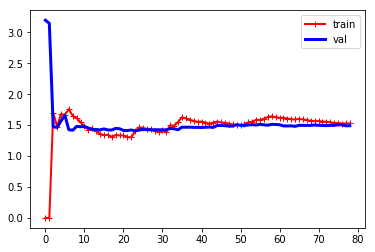

In [19]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X,y)

**These learning curves are typical of an underfitting model.Both curves have reached a plateau;they are very close and fairly high. If your model is underfitting the training data, adding more training examples will not help. You need to use a more complex model or come up with better features.**

In [20]:
def plot_learning_curves2(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.2)
    train_errors, val_errors = [],[]
    for m in range(1, len(X_train)):
        model.fit(X_train[:m],y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train_predict, y_train[:m]))
        val_errors.append(mean_squared_error(y_val_predict, y_val))
    plt.plot(np.sqrt(train_errors),'r-+',linewidth=2, label='train')
    plt.plot(np.sqrt(val_errors),'b-',linewidth=3, label='val')
    plt.axis([0,80,0,3])  
    plt.legend()

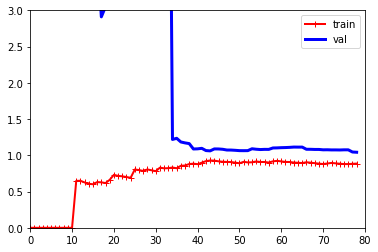

In [21]:
from sklearn.pipeline import Pipeline
polynominal_regression = Pipeline((
    ('poly_features', PolynomialFeatures(degree=10, include_bias=False)), ('sgd_reg', LinearRegression())
                                                                          ))

plot_learning_curves2(polynominal_regression, X, y)

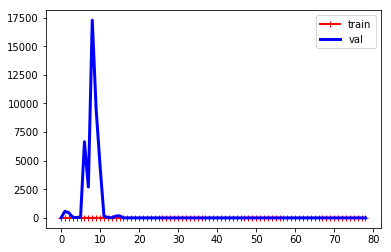

In [22]:
plot_learning_curves(polynominal_regression, X, y)

**The learning curves look a bit bike the previous ones, but there are two very important differences:**
- The error on the training data is much more lower than with the Linear Regression model.
- There is a gap between the curves. This means that the model performs significantly better on the training data than on the validation data, which is the hallmark of an overfitting model. One way to improve an overfitting model is to feed it more training data until the validation error reaches the training error.

#### The Bias/Variance Tradeoff
An important theoretical result of statistics and Machine Learning is the fact that a model's generalization error can be expressed as the sum of three very different errors:
- Bias: This part of the generalization error is due to wrong assumptions, such as assuming that the data is linear when it is actually quadratic(二次的). **A high-bias model is most likely to underfit the training data.**
    
- Variance: This part is due to the model's excessive sensitivity to small variations in the training data. A model with many degrees of freedom(such as a high-degree polynomial model) is likely to have high variance, and thus to overfit the training data.
    
- Irreducible error(不可减少的错误): This part is due to the noisiness of the data itself. The only way to reduce this part of the error is to clean up the data(e.g., fix the data sources, such as broken sensors, or detect and remove outliers).

Increasing a model's complexity will typically increase its variance and reduce its bias. Conversely, reducing a model's  complexity increases its bias and reduces its variance. This is why it is called a tradeoff.

## Regularized Linear Model
A good way to reduce overfitting is to regularize the model: the fewer degrees of freedom it has, the harder it will be for it to overfit the data.

For a linear model, regularization is typically achieved by constraining the weights of the model. We will now see 3 different ways to constrain the weights.

### #1 Ridge Regression岭回归
Ridge Regression(or Tikhonov regularization) is a regularized version of Linear Regression: a **regularization term** equal to $\alpha\sum_{i=0}^{n}\theta_i^2$ is added to the cost function. This forces the learning algorithm to not only fit the data but also keep the model weights as small as posible. **Note that the regularization term should only be added to the cost function during training.** Once the model is trained, you want to evaluate the model's performance using the unregularized performance measure.

Apart regularization, another reason why cost functions may be different is that a good training cost function should have optimization-friendly derivatives, while the performance measure using for testing should be as close as possible to the final objective.

The hyperparameter $\alpha$ controls how much you want to regularize the model. If $\alpha=0$ then Ridge Regression is just Linear Regression. If $\alpha$ is very large, then all weights end up very close to zero and the result is a flat line going through the data's mean.

*Equation4-8. Ridge Regression cost function*
$$J(\theta)=MSE(\theta)+\alpha \frac{1}{2}\sum_{i=1}^{n}\theta_i^2$$

**Note that the bias term $\theta_0$ is not regularized(the sum starts at i=1, not 0)**. Define $w$ as the vector of feature weights($\theta_1$ to $\theta_n$), then the regularization term is simply equal to $\frac{1}{2}(\left\|w\right\|_2)^2$, where $(\left\|·\right\|_2)^2$ represents the L2 norm of teh weight vector. For Gradient Descent, just add $\alpha w$ to the MSE gradient vector.

**It is important to scale the data(e.g., using a `standardScaler`) before performing Ridge Regression, as it is sensitive to the scale of the input features. This is true of most regularized model.**

As with linear regression, we can perform Ridge Regression either by computing a closed-form equation or by performing Gradient Descent. The pros and cons are the same.

*Equation4-9. Ridge Regression closed-form solution*
$$\hat\theta = (X^T\cdot X +\alpha A)^{-1} \cdot X^T \cdot y$$

Below is how to perform Ridge Regression with Scikit-learn using a closed-form solution and Stochastic Gradient Descent:

In [23]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=1, solver='cholesky')
ridge_reg.fit(X,y)
ridge_reg.predict([[1.5]])

array([[4.53821542]])

In [24]:
sgd_reg = SGDRegressor(penalty='l2')
sgd_reg.fit(X, y)
sgd_reg.predict([[1.5]])

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([3.69445972])

The `penalty` hyperparameter sets the type of regularization term to use.

### #2 Lasso Regression
Least Absolute Shrinkage and Selection Operator Regression(short in Lasso Regression) is another regularized version of Linear Regression:it uses the l1 norm of the weight vector.

*Equation 4-10. Lasso Regression cost function*
$$J(\theta)=MSE(\theta)+\alpha \sum_{i=1}^n+\vert\theta_i\vert$$

**An important characteristic of Lasso Regression is that it tends to completely eliminate the weights of the least important features.** In other words, Lasso Regression automatically performs feature selection and outputs a sparse model(i.e., with few nonzero feature weights).

The Lasso cost function is not differentiable(可微的) at $\theta_i=0$(for i = 1,2,...n), but Gradient Descent still works fine if you use a **subgradient vector** instead when any $\theta_i=0$.

*Equation4-11: Lasso Regression subgradient vector:*
$$g(\theta,J)=\nabla_\theta MSE(\theta) +\alpha
\left(
    \begin{matrix}
        sign(\theta_1)\\
        sign(\theta_2)\\
        \vdots\\
        sign(\theta_n)\\
    \end{matrix}
\right)
\text{where}
sign(\theta_i)=
\left(
    \begin{array}
        -1 &\text{if}&\theta_i<0\\
         0 &\text{if}&\theta_i=0\\
        +1 &\text{if}&\theta_i>0
    \end{array}
\right.
$$

Here is a small scikit-learn example using the Lasso class.Note that you could instead use an `SGDRegressor(penalty='11')`.

In [25]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X,y)
lasso_reg.predict([[1.5]])

array([4.48840548])

### Elastic Net
Elastic Net is a middle ground between Ridge Regression and Lasso Regression. The regularization term is a simple mix of both Rigde and Lasso's regualrization terms, and we can control the mix ratio $r$.When $r=0$, it is equivalent to Ridge Regression, and when $r=1$, it is equivalent to Lasso Regression.

*Equation4-11: Lasso Regression subgradient vector:*
$$J(\theta)=MSE(\theta)+r\alpha\sum_{i=1}^n|\theta_i|+\frac{1-r}{2}\alpha\sum_{i=1}^n\theta_i^2$$

**So when should we use Linear Regression, Ridge, Lasso or Elastic Net? Generally we avoid plain Linear Regression. Ridge is a good default, but if you suspect that only a few features are actually useful, you should prefer Lasso or Elastic Net since they tend to reduce the useless features's weights down to zero. In general, Elastic Net is preferred over Lasso since Lasso may behave erratically(不规律的) when the number of features is greater than the number of instances or when several features are strongly correlated.**

In [26]:
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net.fit(X,y)
elastic_net.predict([[1.5]])

array([4.49342015])

### Early Stopping
**Stopping training as soon as the validation error reaches a minimum is called Early Stopping.** It is different way to regularize iterative learning algorithms. When the validation error stops decreasing and actually starts to go back up, it indicates that the model has started to overfit the training data. With eraly stopping, you just stop training as soon as the validation error reaches the minimum.

With SGD and Mini-batch GD, teh curves are not so smooth, and it may be head to know whether you have reached the minimum or not. One solution is to stop only after the validation error has been above the minimum for some time(when you are confident that the model will not do any better), then roll back the model parameters to the point where the validation error was at a minimum.

Here is a basic implementation of early stopping:

In [27]:
import warnings
warnings.filterwarnings('ignore')

In [28]:
from sklearn.base import clone
m = 100
X = 6*np.random.rand(m,1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m,1)

from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(X_poly, y, test_size=0.2)

sgd_reg = SGDRegressor(n_iter=1, warm_start=True, penalty=None, learning_rate='constant', eta0=0.0005)
minimum_val_error = float('inf')
best_epoch = None
best_model = None
for epoch in range(1000):
    sgd_reg.fit(X_train, y_train)#continues where it left off
    y_val_predict = sgd_reg.predict(X_val)
    val_error = mean_squared_error(y_val_predict, y_val)
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = clone(sgd_reg)

Note that with `warm_start=True`, when the `fit()` method is called, it just continues training where it left off instead of restarting from scratch.

# Logistic Regression
Logistic Regression is sommonly used to estimate the probability that an instance belongs to a particular class.

## Estimating Probabilities
A Logistic Regression model computes a weighted sum of the input features(plus a bias term), but instead of outputting the result directly like the Linear of outputting the result directly like the Linear Regression model does, it outputs the **logistic** of this result(Equation 4-13).

*Equation 4-13. Logistic Regression model estimated probability(vectorized form)*
$$\hat{p}=h_\theta(x)=\sigma(\theta^T\cdot x)$$

The logistic, also called the **logit**, noted $\sigma(\cdot)$, is a is a sigmoid function that outputs a number between 0 and 1. It is defined as shown in Equation 4-14.

*Equation 4-14 Logistic funciton*
$$\sigma(t)=\frac{1}{1+exp(-t)}$$
Once the Logistic Regression model has estimated the probability $\hat{p}=h_\theta(x)$ that an instance $x$ belongs to the positive class, it can make its prediction $\hat(y)$ easily. So a Logistic Regression model predicts 1 if $\theta^T\cdot x$ is positive, and 0 if it's negative.

## Training and Cost Function
The objective of training is to set the parameter vector $\theta$ so that the model estimates high probabilities for positive instances(y=1) and low probabilities for negative instances(y=0). This idea is captured by the cost function shown in *Equation 4-16*.

*Equation 4-16. Cost function of a single training instances*
$$c(\theta)=\left\{
\begin{aligned}
-log( \hat {p} ) \\
-log(1- \hat p)
\end{aligned}
\right.$$